In [1]:
#DATA
#SKU - SKU NUmber
#Std. Price ($) - Price of each unit of SKU
#On-Hand Stock ($) - Total stock on-hand as of 30th Sep'20	 
#APU (units) - Average monthly consumption (30 days) of the SKU
#APU Trend - Anticipated APU trend provided by marketing (e.g. 50% indicates 50% increase in APU consumption)
#S-OTD - Supplier On-time delivery (S-OTD) performance for the past 12 months
#Demand variability (COV) - Demand Coefficient of variance for the past 12 months
#Lead Time (days) - Lead time in days to procure the SKU

#Assumptions to be taken into consideration:
# The Minimum Order Quantity (MOQ) is equal to one lead-time demand
# The service level targeted can be assumed to be 95%
# The expiry for all the mentioned SKUs is one year

#FIND THE FOLLOWING
# Estimate the change in the inventory position to understand the working capital impact  
# Based on the marketing insights gathered, understand the potential obsolete inventory that they currently have

In [52]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from pprint import pprint
from scipy import special, stats
from itertools import islice 
import seaborn as sns

In [3]:
#getting data
xls = pd.ExcelFile('2021-ascm-case-competition_school-round_data-exhibits.xlsx')
df = pd.read_excel(xls, 'Data Exhibit-2')

print(list(df.columns))
print(df.dtypes)
df.head()

['SKU ', 'Std. Price ($)', 'On-Hand Stock ($)', 'APU\n(units)', 'APU Trend', 'S-OTD', 'Demand variability (COV)', 'Lead Time (days)']
SKU                         float64
Std. Price ($)              float64
On-Hand Stock ($)           float64
APU\n(units)                  int64
APU Trend                   float64
S-OTD                       float64
Demand variability (COV)    float64
Lead Time (days)              int64
dtype: object


,SKU,Std. Price ($),On-Hand Stock ($),APU\n(units),APU Trend,S-OTD,Demand variability (COV),Lead Time (days)
0,14171.732125,33.762953,5837.312718,122,-0.1,0.77,1.56,23
1,52169.042825,12.089326,1532.719476,178,0.2,0.85,1.80,12
2,72156.257446,11.756134,4562.334137,324,-0.4,0.77,1.38,21
3,8954.076984,8.157692,4156.895262,414,0.5,0.70,1.99,15
4,94785.831804,5.269414,587.585764,170,1.2,0.80,0.92,15


In [4]:
#Get demand data
monthly_demand = [0] * len(df.index)
daily_demand = [0] * len(df.index)
initial_inventory = []

for sku in range(len(df.index)):
    monthly_demand[sku] = df.at[sku, 'APU\n(units)'] * (1 + df.at[sku, 'APU Trend'])
    daily_demand[sku] = monthly_demand[sku]/30
    initial_inventory.append(df.at[sku, 'On-Hand Stock ($)'] / df.at[sku, 'Std. Price ($)'])
    
#print(initial_inventory)

In [5]:
#Calculate ROQ
Z_alpha = 1.645 #as service level is 95% http://www.math.armstrong.edu/statsonline/5/5.3.2.html

def ROQ(sku):
    m_d = daily_demand[sku]
    s_d = m_d / df.at[sku, 'Demand variability (COV)']
    
    m_l = df.at[sku, 'Lead Time (days)'] * df.at[sku, 'S-OTD']
    x_l = df.at[sku, 'Lead Time (days)']       
    ##SOURCE: 
        #https://math.stackexchange.com/questions/2560644/calculate-z-score-given-probability-using-erfinv
        #https://www.wolframalpha.com/input/?i=normal+distribution
    ##VERIFICATION:
        #https://stattrek.com/online-calculator/normal.aspx
    z_l = -np.sqrt(2)*special.erfcinv(2*df.at[sku, 'S-OTD'])
    s_l = (x_l - m_l)/ z_l
    
    expected_demand = daily_demand[sku] * df.at[sku, 'Lead Time (days)']        
    safety_stock = Z_alpha * np.sqrt(m_l * s_d**2 + m_d**2 * s_l**2)
    
    return expected_demand + safety_stock, expected_demand, safety_stock

In [7]:
obsolete_skus = []
obsolete_inventory = []
total_obsolete_inventory_safety_stock = 0
total_obsolete_inventory = 0
ObsoleteKPI = []

for sku in range(len(df.index)):
    #Finding safety stock of SKUs
    _, _, ss = ROQ(sku)
    
    #Condition for obsoletion
    if initial_inventory[sku] > (daily_demand[sku] * 360 + ss): 
        obsolete_skus.append(sku)
        obsolete_inventory.append(initial_inventory[sku] - (daily_demand[sku] * 360 + ss))
        total_obsolete_inventory += (initial_inventory[sku] - (daily_demand[sku] * 360 + ss)) * df.at[sku, 'Std. Price ($)']
        total_obsolete_inventory_safety_stock += ss * df.at[sku, 'Std. Price ($)'] #Rohan's Insight
        ObsoleteKPI.append((initial_inventory[sku] - (daily_demand[sku] * 360 + ss)) / ss)
        #hist_data.append((df.at[i, 'Initial Inventory'] - df.at[i, 'Yearly Demand'] - ss) / ss )
        #n, bins, patches = plt.hist(x=hist_data, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
        #print("Safety Stock of SKU {} is {}".format(i, ss * df.at[i, 'Std. Price ($)']))
        #print("Obsolete Invt. of SKU {} is {}".format(i, (df.at[i, 'Initial Inventory'] - df.at[i, 'Yearly Demand'] - ss) * df.at[i, 'Std. Price ($)']))

print("Obsolete Inventory :", sum(obsolete_inventory), "$")
print("KPI || Obsolete Inventory / Safety Stock :", sum(obsolete_inventory)/ total_obsolete_inventory_safety_stock * 100, "%") #Rohan's Insight
print(obsolete_skus)
print(obsolete_inventory)
print(len(obsolete_skus))
print(ObsoleteKPI)

#ABC Classification
os_A = []
os_B = []
os_C = []

for i in range(len(ObsoleteKPI)):
    if ObsoleteKPI[i] >= 100:
        os_C.append([obsolete_skus[i], ObsoleteKPI[i]])
    elif ObsoleteKPI[i] >= 10:
        os_B.append([obsolete_skus[i], ObsoleteKPI[i]])
    else:
        os_A.append([obsolete_skus[i], ObsoleteKPI[i]])

print("SKU's in CLASS C (Obsolete/SS >= 100) is {} (i.e. {} % of total Obsolete SKUs)".format(np.array(os_C).shape[0], np.array(os_C).shape[0] / len(obsolete_skus) * 100))
print("SKU's in CLASS B (100 > Obsolete/SS >= 10) is {} (i.e. {} % of Obsolete SKUs)".format(np.array(os_B).shape[0], np.array(os_B).shape[0] / len(obsolete_skus) * 100))
print("SKU's in CLASS A (10> Obsolete/SS) is {} (i.e. {} % of Obsolete SKUs)".format(np.array(os_A).shape[0], np.array(os_A).shape[0] / len(obsolete_skus) * 100))

Obsolete Inventory : 46263.57538621479 $
KPI || Obsolete Inventory / Safety Stock : 115.44658518772559 %
[9, 19, 37, 41, 54, 57, 58, 60, 61, 86, 99, 113, 118, 121, 124, 138, 144, 179, 185, 201, 394, 490, 501, 590, 636, 664, 683, 969, 1843, 1846, 1910]
[7054.929611924415, 23.455517273783897, 471.8491312792628, 455.61909141022113, 6.117784186585489, 1369.4407809565737, 184.19320631230096, 249.79743711077188, 16.056942337542907, 9148.130334006291, 734.9864854420497, 754.3254397239319, 79.35269801679692, 411.0844955618844, 161.92084430294346, 598.4177232310847, 5817.4685016192125, 46.05154748695031, 137.17935086870952, 1818.3156140905262, 8995.687645425369, 7.99685496729532, 602.0434740461274, 56.87285365345387, 569.1723677754883, 971.4370829137039, 409.384414735838, 341.60912263562807, 669.1315675184246, 2119.8912314414993, 1981.656233960135]
31
[387.42024875287876, 13.015781206439609, 303.57647929572954, 22.50589094299842, 8.40264173127705, 37.5637928778158, 92.47035027043022, 71.5361405

In [44]:
#Final Inventory Levels
lots_ordered = [0] * len(df.index)
day_counter = [0] * len(df.index)
stockout_units = [0] * len(df.index)

number_of_orders = [ [0]*360 for _ in range(len(df.index)) ]
inventory_level = [ [0]*360 for _ in range(len(df.index)) ]
arrival = [ [0]*360 for _ in range(len(df.index)) ]

for sku in range(0, len(df.index)):
    inventory_level[sku][0] = initial_inventory[sku]
    
    for day in range(0, 360):
        #Calculating daily inventory levels of all SKUs
        if day != 0:
            inventory_level[sku][day] = inventory_level[sku][day - 1] - daily_demand[sku]
            if (inventory_level[sku][day] < 0 and arrival[sku][day] == 0):
                stockout_units[sku] += abs(inventory_level[sku][day])
                inventory_level[sku][day] = 0
            inventory_level[sku][day] += arrival[sku][day]
            
        if day_counter[sku] == 0:
            roq, LT_demand, ss = ROQ(sku)
            oq = LT_demand + ss
        
            if inventory_level[sku][day] <= roq:
                    number_of_orders[sku][day] += 1
                    try:
                        arrival[sku][day + df.at[sku, 'Lead Time (days)']] += oq
                    except IndexError:
                        pass
                    lots_ordered[sku] += oq
                    day_counter[sku] = df.at[sku, 'Lead Time (days)']
                    
        else:
            day_counter[sku] -= 1
            continue

In [27]:
#Checking for Individual Units
i = 3

#Debugging Orders
print(number_of_orders[i])


print("Number of times ordered is : {}".format(np.array(number_of_orders[i]).sum()))
print("Units Ordered are : {}".format(lots_ordered[i]))
print("Inventory Ordered is : {} $".format(lots_ordered[i] * df.at[i, 'Std. Price ($)']))
print("StockOut Loss is : {} $".format(stockout_units[i] * df.at[i, 'Std. Price ($)']))
print("StockOut Units are : {}".format(stockout_units[i]))
print("Total demand is : {}".format(daily_demand[i] * 360))
print("Service Level is : {} %".format(100 - (stockout_units[i] / (daily_demand[i] * 360) * 100)))

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [45]:
#KPIs
total_ordering_cost = 0
total_stockout_loss = 0
total_demand = 0

for i in range(len(df.index)):
    total_ordering_cost += lots_ordered[i] * df.at[i, 'Std. Price ($)']
    total_stockout_loss += stockout_units[i] * df.at[i, 'Std. Price ($)']
    total_demand += daily_demand[i] * 360 * df.at[i, 'Std. Price ($)']
    
print("Total Inventory Ordered is : {} $".format(total_ordering_cost))
print("Total StockOut Loss is : {} $".format(total_stockout_loss))
print("Total Demand is : {} $".format(total_demand))
print("Total Service Level is : {} %".format(100 - total_stockout_loss / total_demand * 100))

print("Total Working Capital Impact (Initial Inventory + Total Inventory Ordered) is : {} $".format(df['On-Hand Stock ($)'].sum() + total_ordering_cost))
total_initial_inventory = df['On-Hand Stock ($)'].sum(axis = 0)
print("Total Initital Inventory is : {} $".format(total_initial_inventory))

total_final_inventory = 0
for sku in range(np.array(inventory_level).shape[0]):
    total_final_inventory += inventory_level[sku][359] * df.at[sku, 'Std. Price ($)']
print("Total Final Inventory is : {} $".format(total_final_inventory))

print("Change in Inventory Position is : {} $".format(total_final_inventory - total_initial_inventory))

Total Inventory Ordered is : 1007037777.6721174 $
Total StockOut Loss is : 49141507.25017719 $
Total Demand is : 848623825.1087852 $
Total Service Level is : 94.20927084578638 %
Total Working Capital Impact (Initial Inventory + Total Inventory Ordered) is : 1053045977.4578924 $
Total Initital Inventory is : 46008199.785775006 $
Total Final Inventory is : 160959590.05536062 $
Change in Inventory Position is : 114951390.26958561 $


In [34]:
#Service Level Classes
service_level = [0] * len(df.index)
sl_A = []
sl_B = []
sl_C = []

for sku in range(0, len(df.index)):
    service_level[sku] = 100 - stockout_units[sku]/ (daily_demand[sku] * 360) * 100
    #print("SKU {} : Service Level is {} %".format(sku, 100 - stockout_units[sku]/ sum(sku_daily_demand[sku]) * 100))

print("Average Service Level is {} %".format(np.mean(service_level)))

for sku in range(0, len(df.index)):
    if 100 - (stockout_units[sku]/ (daily_demand[sku] * 360) * 100) >= 95:
        sl_A.append([sku, service_level[sku]])
    elif 100 - (stockout_units[sku]/ (daily_demand[sku] * 360) * 100) >= 90:
        sl_B.append([sku, service_level[sku]])
    else:
        sl_C.append([sku, service_level[sku]])

print("SKU's in CLASS A (Service Level >= 95%) is {} (i.e. {} % of total SKUs)".format(np.array(sl_A).shape[0], np.array(sl_A).shape[0] / len(df.index) * 100))
print("SKU's in CLASS B (95% > Service Level >= 90%) is {} (i.e. {} % of total SKUs)".format(np.array(sl_B).shape[0], np.array(sl_B).shape[0] / len(df.index) * 100))
print("SKU's in CLASS C (90% > Service Level) is {} (i.e. {} % of total SKUs)".format(np.array(sl_C).shape[0], np.array(sl_C).shape[0] / len(df.index) * 100))
pprint(sl_C)

Average Service Level is 97.84471895512577 %
SKU's in CLASS A (Service Level >= 95%) is 1740 (i.e. 86.56716417910447 % of total SKUs)
SKU's in CLASS B (95% > Service Level >= 90%) is 188 (i.e. 9.35323383084577 % of total SKUs)
SKU's in CLASS C (90% > Service Level) is 82 (i.e. 4.079601990049751 % of total SKUs)
[[26, 81.2977889328172],
 [28, 86.98637991772793],
 [105, 72.52120397225605],
 [127, 67.59214345715881],
 [142, 86.61352528906342],
 [149, 70.01231889075369],
 [160, 85.47797419572643],
 [166, 85.11079245301464],
 [170, 89.29473382871342],
 [365, 79.68807601301387],
 [379, 89.74859621025065],
 [386, 87.66063675269382],
 [388, 75.80183275448115],
 [413, 85.99011815552153],
 [432, 85.41045077431176],
 [458, 60.55599904587361],
 [465, 71.64290480801563],
 [478, 85.67396976454803],
 [480, 89.57924447431301],
 [497, 86.35777002615576],
 [517, 85.33757294914031],
 [537, 88.971866951752],
 [563, 89.375691612739],
 [613, 85.48579425929809],
 [1019, 84.50135591940901],
 [1059, 88.1486649

Average Daily Inventory is : 144222124.29752296 $
Average Monthly Inventory is : 4326663728.925693 $
28389584.649633598 180134993.37825003


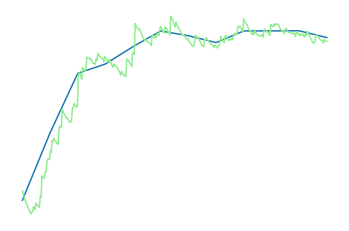

In [62]:
#Calculate Average Inventory
daily_inventory = [0] * 360
monthly_inventory = [0] * 12

for day in range(0, 360):
    month = int(day / 30)
    for sku in range(0, len(df.index)):
        daily_inventory[day] += inventory_level[sku][day] * df.at[sku, 'Std. Price ($)']
        monthly_inventory[month] += inventory_level[sku][day] * df.at[sku, 'Std. Price ($)']

print("Average Daily Inventory is : {} $".format(np.mean(daily_inventory)))
print("Average Monthly Inventory is : {} $".format(np.mean(monthly_inventory)))
plt.plot(np.linspace(0, 1, 12), stats.zscore(np.abs(monthly_inventory)))
plt.plot(np.linspace(0, 1, 360), stats.zscore(np.abs(daily_inventory)), c = 'lightgreen')
plt.axis('off')

print(min(daily_inventory), max(daily_inventory))

On average 77 SKUs are placed on order for replenishment.


([<matplotlib.axis.XTick at 0x22b2e5da490>,
 [Text(0.5, 0, '1'),
  Text(1.5, 0, '2'),
  Text(2.5, 0, '3'),
  Text(3.5, 0, '4'),
  Text(4.5, 0, '5'),
  Text(5.5, 0, '6'),
  Text(6.5, 0, '7'),
  Text(7.5, 0, '8'),
  Text(8.5, 0, '9'),
  Text(9.5, 0, '10'),
  Text(10.5, 0, '11'),
  Text(11.5, 0, '12'),
  Text(12.5, 0, '13'),
  Text(13.5, 0, '14'),
  Text(14.5, 0, '15'),
  Text(15.5, 0, '16'),
  Text(16.5, 0, '17'),
  Text(17.5, 0, '18'),
  Text(18.5, 0, '19'),
  Text(19.5, 0, '20'),
  Text(20.5, 0, '21'),
  Text(21.5, 0, '22'),
  Text(22.5, 0, '23'),
  Text(23.5, 0, '24'),
  Text(24.5, 0, '25'),
  Text(25.5, 0, '26'),
  Text(26.5, 0, '27'),
  Text(27.5, 0, '28'),
  Text(28.5, 0, '29'),
  Text(29.5, 0, '30'),
  Text(30.5, 0, '31'),
  Text(31.5, 0, '32'),
  Text(32.5, 0, '33'),
  Text(33.5, 0, '34'),
  Text(34.5, 0, '35'),
  Text(35.5, 0, '36'),
  Text(36.5, 0, '37'),
  Text(37.5, 0, '38'),
  Text(38.5, 0, '39'),
  Text(39.5, 0, '40'),
  Text(40.5, 0, '41'),
  Text(41.5, 0, '42'),
  Text(42

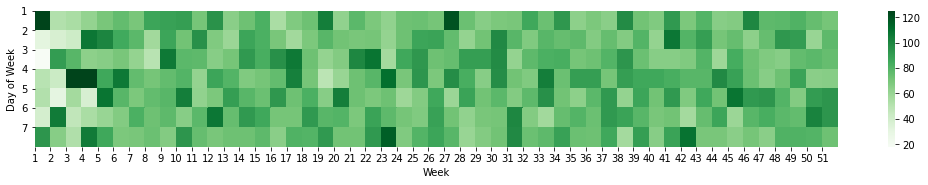

In [47]:
#Order Aggregation
order_aggregation  = np.array(number_of_orders).sum(axis=0)
#print(order_aggregation)

print("On average {} SKUs are placed on order for replenishment.".format(int(np.mean(order_aggregation[1:]))))

for i in range(len(order_aggregation)):
    if(order_aggregation[i] > 150):
        order_aggregation[i] = 125

Inputt = iter(order_aggregation) 
Output = [list(islice(Inputt, 7)) for _ in range(int(360/7))] 

#handling anomaly
Output[0][0] = 125

plt.figure(figsize = (18, 2.5))

#Color Templates - https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f
sns.heatmap(np.transpose(Output), cmap="Greens") 

#plt.title('Heatmap of Number of Orders')
plt.xlabel('Week')
plt.ylabel('Day of Week')
plt.yticks(range(0, 7), range(1, np.array(np.transpose(Output)).shape[0] + 1), rotation = 'horizontal')
plt.xticks(range(0, 51), range(1, np.array(np.transpose(Output)).shape[1] + 1), rotation = 'horizontal')

In [41]:
#Inventory Level Analyzer
analyze_sku = 1967
roq, ltd, ss = ROQ(analyze_sku)
print("SS = {}, ROQ = {}, LTD = {}, LT = {}".format(ss, roq, ltd, df.at[analyze_sku, 'Lead Time (days)']))
ans = pd.DataFrame({'Inventory': inventory_level[analyze_sku], 'Arrival': arrival[analyze_sku], 'Demand': daily_demand[analyze_sku]})
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(ans)
    
#plt.plot(ans['Inventory'])

SS = 89423.48837571096, ROQ = 172068.32170904428, LTD = 82644.83333333333, LT = 61
         Inventory        Arrival       Demand
0     20537.435516       0.000000  1354.833333
1     19182.602183       0.000000  1354.833333
2     17827.768850       0.000000  1354.833333
3     16472.935516       0.000000  1354.833333
4     15118.102183       0.000000  1354.833333
5     13763.268850       0.000000  1354.833333
6     12408.435516       0.000000  1354.833333
7     11053.602183       0.000000  1354.833333
8      9698.768850       0.000000  1354.833333
9      8343.935516       0.000000  1354.833333
10     6989.102183       0.000000  1354.833333
11     5634.268850       0.000000  1354.833333
12     4279.435516       0.000000  1354.833333
13     2924.602183       0.000000  1354.833333
14     1569.768850       0.000000  1354.833333
15      214.935516       0.000000  1354.833333
16        0.000000       0.000000  1354.833333
17        0.000000       0.000000  1354.833333
18        0.000000      